# Anomaly detection in Global Burden of Disease data

> **Data Source and Licensing**
>
> Source: Institute for Health Metrics and Evaluation (IHME). Used with permission. All rights reserved.  
> This analysis uses Global Burden of Disease (GBD) estimates from 2023, released in 2025.
> The underlying data are not included in this repository due to licensing restrictions.  
> All visualizations and results shown are derived outputs shared for non-commercial, educational, and portfolio purposes in accordance with IHME’s Free-of-Charge Non-Commercial User Agreement.

## Introduction

Understanding differences in mortality patterns across countries is essential for improving population health, guiding public health policy, and identifying areas where health systems may be under particular strain. While global mortality trends often follow broad and predictable patterns, some countries exhibit unusual or extreme cause-of-death profiles that merit closer investigation. Detecting such anomalies can help highlight potential public health challenges, data-quality issues, or structural health inequalities that may otherwise go unnoticed.

In this project, I apply anomaly detection techniques to country-level mortality data from the Global Burden of Disease (GBD) 2025 release, which reports estimates for the year 2023. The dataset contains cause-specific death rates per 100,000 population for countries worldwide, grouped into 20 major disease and injury categories, including cardiovascular diseases, neoplasms, infectious diseases, maternal and neonatal disorders, and injuries. Each country is represented by a profile describing how mortality is distributed across these causes.

The objective of this analysis is to identify countries whose mortality patterns deviate substantially from the global norm. Such deviations do not automatically imply data errors or policy failures; instead, they serve as signals for further investigation, helping researchers and decision-makers prioritize attention and resources.

Following data preprocessing and exploratory data analysis (EDA), several complementary anomaly detection approaches are applied:

- Interquartile Range (IQR): a univariate statistical method used to identify unusually high or low death rates within individual causes.

- One-Class Support Vector Machine (SVM): a machine learning technique designed to detect abnormal observations in high-dimensional data.

- Isolation Forest: an ensemble-based algorithm well suited for multivariate anomaly detection.

- Principal Component Analysis (PCA): used for dimensionality reduction and visualization of country-level mortality patterns and detected anomalies.

By comparing results across statistical and machine learning methods, this project aims to increase confidence in the identified anomalies and to demonstrate how multivariate approaches can capture complex patterns that may not be visible when examining causes of death in isolation.

How do anomaly detection results differ between statistical and machine learning approaches?

To what extent do multivariate methods provide additional insight beyond univariate analysis?

Ultimately, this project illustrates how data-driven techniques can support global health analysis by identifying atypical mortality patterns that warrant closer examination by researchers, policymakers, and public health stakeholders.

## Public health context and analytical considerations

In population health data, anomalies typically represent a small fraction of observations, often on the order of a few percent. However, unlike operational sensor data, deviations in health outcomes must be interpreted with care. An unusually high death rate from a single cause may reflect well-known epidemiological realities (such as regional disease burdens) rather than a true abnormality.

For this reason, the analysis emphasizes not only univariate outliers but also combinations of causes. For example, a country may not appear anomalous when considering cardiovascular mortality alone, but a simultaneous elevation across cardiovascular diseases, diabetes, and kidney disease may indicate broader systemic health challenges. Conversely, low mortality from certain causes may reflect demographic structure, reporting practices, or successful prevention strategies.

Because this project is conducted without direct input from national health authorities or domain experts for individual countries, detected anomalies should be viewed as hypotheses rather than conclusions. The results are intended to support exploratory analysis, highlight patterns of interest, and demonstrate how anomaly detection methods can be applied to large-scale global health data.

## Project aim

The goal of this notebook is to develop and evaluate a robust, transparent anomaly detection workflow for country-level mortality profiles using GBD data. Specifically, the analysis seeks to answer:

Which countries exhibit unusual mortality patterns across multiple causes?

## Import libraries and dataset

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [2]:
# Import the dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import the dataset
gbd = pd.read_csv('/content/drive/MyDrive/GBD.csv')

# View dataframe
# gbd.head()

In [4]:
gbd.shape

(4284, 10)

The dataframe has 4284 rows and 10 features: measure, location, sex, age, cause, metric, year, val (value), upper and lower.

## Preprocessing

I will keep only the important features: location, cause and value.

In [5]:
# Keep only location, cause and value, drop the rest
gbd_clean = gbd[['location', 'cause', 'val']].copy()
# gbd_clean.head()

I want to set the location as index and the causes as columns.

In [6]:
# set location as index and causes as columns
gbd_clean = gbd_clean.pivot(index='location', columns='cause', values='val')
# gbd_clean.head()

In [7]:
gbd_clean.shape

(204, 21)

The dataframe now has 204 rows (the countries) and 21 variables (the grouped causes of death).

In [8]:
# identify missing values
gbd_clean.isnull().sum()

,0
cause,
Cardiovascular diseases,0
Chronic respiratory diseases,0
Diabetes and kidney diseases,0
Digestive diseases,0
Enteric infections,0
HIV/AIDS and sexually transmitted infections,0
Maternal and neonatal disorders,0
Mental disorders,0
Musculoskeletal disorders,0


In [9]:
# Identify duplicate values
gbd_clean.duplicated().sum()

np.int64(0)

The dataframe does not contain missing or duplicate values.

In [10]:
# check the arguments of the describe() function
help(gbd_clean.describe)

Help on method describe in module pandas.core.generic:

describe(percentiles=None, include=None, exclude=None) -> 'Self' method of pandas.core.frame.DataFrame instance
    Generate descriptive statistics.

    Descriptive statistics include those that summarize the central
    tendency, dispersion and shape of a
    dataset's distribution, excluding ``NaN`` values.

    Analyzes both numeric and object series, as well
    as ``DataFrame`` column sets of mixed data types. The output
    will vary depending on what is provided. Refer to the notes
    below for more detail.

    Parameters
    ----------
    percentiles : list-like of numbers, optional
        The percentiles to include in the output. All should
        fall between 0 and 1. The default is
        ``[.25, .5, .75]``, which returns the 25th, 50th, and
        75th percentiles.
    include : 'all', list-like of dtypes or None (default), optional
        A white list of data types to include in the result. Ignored
        fo

There is a percentiles argument that can be included in the descriptive statistics. I will use this to find the 95 percentile.

## Exploratory Data Analysis for outliers

In [11]:
# Generate descriptive statistics including 95th percentile
gbd_clean.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

cause,Cardiovascular diseases,Chronic respiratory diseases,Diabetes and kidney diseases,Digestive diseases,Enteric infections,HIV/AIDS and sexually transmitted infections,Maternal and neonatal disorders,Mental disorders,Musculoskeletal disorders,Neglected tropical diseases and malaria,...,Neurological disorders,Nutritional deficiencies,Other infectious diseases,Other non-communicable diseases,Respiratory infections and tuberculosis,Self-harm and interpersonal violence,Skin and subcutaneous diseases,Substance use disorders,Transport injuries,Unintentional injuries
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,243.711209,32.065089,60.328470,33.205905,13.446664,19.271370,24.624383,0.003737,1.447694,11.243364,...,36.931873,3.414064,11.359125,20.124810,59.983425,21.007293,3.242212,4.348316,17.360667,27.077018
std,159.831779,20.341502,43.110681,14.440546,24.963512,43.702941,32.553367,0.009095,1.234645,26.306837,...,31.918148,3.940317,18.684150,8.439935,36.242302,31.098478,3.905481,5.670070,13.263629,16.585760
min,32.720293,2.183945,9.870899,3.773189,0.094260,0.110713,0.325759,0.000013,0.009172,0.002314,...,3.745701,0.037271,0.448269,2.864793,5.730961,1.834524,0.023930,0.043155,2.093241,5.569066
25%,128.241649,15.795094,30.473419,24.012000,1.441532,0.786941,2.344576,0.000070,0.474646,0.093601,...,14.369787,0.613977,1.943022,14.006995,33.609649,9.907018,1.258575,1.051732,8.181771,18.236186
50%,210.869002,27.298633,46.326331,31.273102,3.409097,3.748382,9.515225,0.000175,1.035263,0.334052,...,22.930434,2.314165,3.379659,19.589595,53.055168,15.695739,2.053603,2.262487,13.846469,24.954960
75%,311.732035,41.848224,72.529392,42.220608,16.119893,13.704561,34.842058,0.001105,2.052926,3.905370,...,51.575927,4.982603,12.242445,24.214048,79.738349,23.095139,3.660488,4.879499,21.856395,32.878139
95%,602.112375,72.425061,148.848990,58.109115,47.770515,99.589241,93.592844,0.021916,4.042128,83.378176,...,96.320991,10.075545,46.132632,36.098341,131.561207,49.707253,9.982337,16.429717,42.388906,48.640622
max,893.102313,99.043767,271.019369,93.884895,203.090771,319.108301,156.189503,0.062170,5.750762,144.446325,...,195.534427,32.394437,150.550935,48.017662,234.879456,414.057271,39.154371,35.785776,86.170344,190.885731


In [12]:
# Generate an overview of the mean values for each cause
gbd_mean = gbd_clean.mean()

# Sort values
gbd_mean = gbd_mean.sort_values(ascending=True)

gbd_mean

,0
cause,
Mental disorders,0.003737
Musculoskeletal disorders,1.447694
Skin and subcutaneous diseases,3.242212
Nutritional deficiencies,3.414064
Substance use disorders,4.348316
Neglected tropical diseases and malaria,11.243364
Other infectious diseases,11.359125
Enteric infections,13.446664
Transport injuries,17.360667


In this overview of mean death rates for each feature we can see that certain features (such as mental disorders and musculosceletar disorders) have a much smaller mean than others (such as neoplasms or cardiovascular diseases). As these can add noise to anomalty detection methods, I will later exclude the ones that contribute less than 1% to the total variance.

In [13]:
# Overview of all features
columns = gbd_clean.columns
for col in columns:
    print(col)

Cardiovascular diseases
Chronic respiratory diseases
Diabetes and kidney diseases
Digestive diseases
Enteric infections
HIV/AIDS and sexually transmitted infections
Maternal and neonatal disorders
Mental disorders
Musculoskeletal disorders
Neglected tropical diseases and malaria
Neoplasms
Neurological disorders
Nutritional deficiencies
Other infectious diseases
Other non-communicable diseases
Respiratory infections and tuberculosis
Self-harm and interpersonal violence
Skin and subcutaneous diseases
Substance use disorders
Transport injuries
Unintentional injuries


In [14]:
# Make sure 'location' is a column for plotting
df_plot = gbd_clean.reset_index()

In [110]:
def create_boxplot_histogram(df, cause, color):
    fig = px.histogram(
        df,
        x=cause,
        nbins=75,
        marginal="box",
        hover_data=["location"],
        template="plotly_white",
        title=f"Distribution of {cause}",
        color_discrete_sequence=[color]
    )

    fig.update_traces(
        marker=dict(
            line=dict(width=1.5, color="black")
        ),
        opacity=0.8
    )

    fig.update_layout(
        width=800,
        height=800,
        xaxis_title=f"{cause} (per 100,000 population)",
        yaxis_title="Number of countries",
        title_font_size=20,
    )

    fig.show()

In [111]:
# Create plotly visualizations for death rate from malaria and NTDs
create_boxplot_histogram(df_plot, "Neglected tropical diseases and malaria", "#2E7D32")

The histogram and boxplot now look completely different. They do not follow a normal/Gaussian-like distribution (bell-shaped curve). There are many countries which do not have deaths from malaria or NTDs and there is a long tail to the right with several outlier. The most notable outliers are Sierra Leone and Niger with high death rates for malaria and NTDs.

In [112]:
# Generate plotly for diabetes and kidney diseases
create_boxplot_histogram(df_plot, "Diabetes and kidney diseases", "#E67E22")

The distribution of death rates for diabetes and kidney diseases has a Gaussian-like distribution, but is skewed to the right: there are many outliers on the right side. Outliers with high death rates include: Mauritius, Fiji, Trinidad and Tobago, Niue and Puerto Rico.

In [113]:
# Create plotly visualisations for cardiovascular diseases
create_boxplot_histogram(df_plot, "Cardiovascular diseases", "#B71C1C")

Cardiovascular diseases death rates show a bell-like shaped curve with a tail to the right (skewed to the right). Outlier with high death rates are Bulgaria, Ukraine, Belarus, Latvia and Lithuania.

In [118]:
# Create plotly visualisations for interpersonal violence
create_boxplot_histogram(df_plot, "Self-harm and interpersonal violence", "#4A148C")

One clear outlier can be seen when looking at the boxplot and histogram for self-harm and interpersonal violence: Palestine. Other outliers include Greenland, Ukraine, Russian Federation and Lesotho.

## Feature Scaling

As some of the features are not normally distributed or contain many outliers and are heavily skewed, I will use the RobustScaler on all features. This ensures that scaling is consistent between features while ensuring that outliers do not dominate the scaling.

In [17]:
# Feature scaling using RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
gbd_scaled = scaler.fit_transform(gbd_clean)

# Convert the NumPy array back to a Pandas DataFrame
gbd_scaled = pd.DataFrame(gbd_scaled, columns=gbd_clean.columns, index=gbd_clean.index)

# view output
# gbd_scaled.head()

Text(0.5, 1.0, 'Distribution of NTD and malaria death rates across countries')

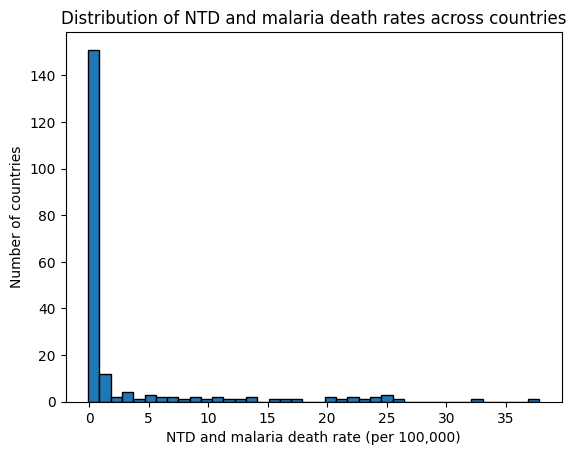

In [18]:
plt.hist(
    gbd_scaled['Neglected tropical diseases and malaria'],
    bins=40,
    edgecolor='black'
)
plt.xlabel("NTD and malaria death rate (per 100,000)")
plt.ylabel("Number of countries")
plt.title("Distribution of NTD and malaria death rates across countries")

Text(0.5, 1.0, 'Distribution of Diabetes and kidney disease death rates across countries')

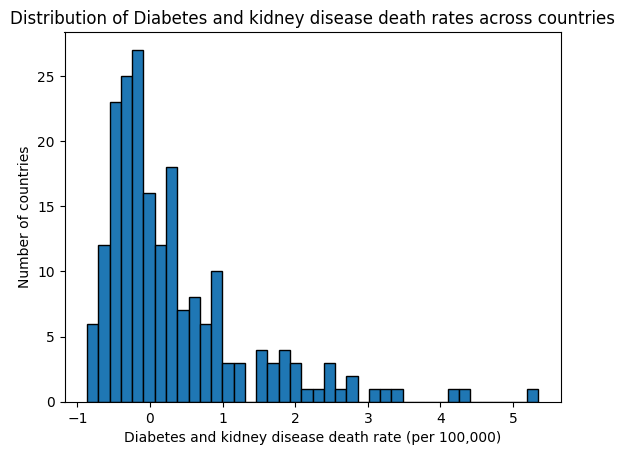

In [19]:
plt.hist(
    gbd_scaled['Diabetes and kidney diseases'],
    bins=40,
    edgecolor='black'
)
plt.xlabel("Diabetes and kidney disease death rate (per 100,000)")
plt.ylabel("Number of countries")
plt.title("Distribution of Diabetes and kidney disease death rates across countries")

The histograms shapes remain unchanged after feature scaling.

## Identifying outliers using IQR

In [20]:
# Calculate IQR and identify outliers for each feature
Q1 = gbd_scaled['Cardiovascular diseases'].quantile(0.25)
Q3 = gbd_scaled['Cardiovascular diseases'].quantile(0.75)
IQR = Q3 - Q1
# View output
print("Q1 is:", Q1)
print("Q3 is:", Q3)
print("IQR is:", IQR)

Q1 is: -0.4503088970679908
Q3 is: 0.5496911029320092
IQR is: 1.0


The Q1 has a negative value. This is because scaled data are used. Both scaled or unscaled data can be used for the IQR method.

In [21]:
# Filter the outliers
# Calculate the upper and lower limits
upper_limit = Q3 + 1.5 * IQR
lower_limit = Q1 - 1.5 * IQR
# View output
print("Upper limit is:", upper_limit)
print("Lower limit is:", lower_limit)

Upper limit is: 2.0496911029320093
Lower limit is: -1.9503088970679907


The values of the upper and lower limit are shown. Any values under the lower limit or above the upper limit are anomalies

In [22]:
# Filter out the lower and upper bounds to find all the anomalies
anomalies_cardio = gbd_scaled[(gbd_scaled['Cardiovascular diseases'] < lower_limit) |
 (gbd_scaled['Cardiovascular diseases'] > upper_limit)
 ]

# Sort the anomalies
anomalies_cardio = anomalies_cardio.sort_values(by='Cardiovascular diseases', ascending=False)

# View output
print(anomalies_cardio.shape)
anomalies_cardio['Cardiovascular diseases']

(11, 21)


,Cardiovascular diseases
location,
Bulgaria,3.718087
Ukraine,3.441266
Belarus,3.241493
Latvia,3.073087
Lithuania,2.668675
Serbia,2.554497
Romania,2.465165
Georgia,2.275744
Hungary,2.217215


### Outliers per feature

I will do the same for the other features, but now using a function.

In [23]:
def iqr_outliers(df, column, k=1.5, sort_desc=True, verbose=True):
    """
    Identify IQR-based outliers for a single column in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the feature.
    column : str
        Name of the column to analyse.
    k : float, optional
        IQR multiplier (default 1.5).
    sort_desc : bool, optional
        Sort anomalies from high to low if True (default True).
    verbose : bool, optional
        If True, print Q1, Q3, IQR and limits.

    Returns
    -------
    anomalies : pd.DataFrame
        Subset of df with only the anomalous rows for the given column.
        Includes the selected column and keeps the original index (locations).
    """

    # Calculate quartiles and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Limits
    lower_limit = Q1 - k * IQR
    upper_limit = Q3 + k * IQR

    if verbose:
        print(f"\n=== {column} ===")
        print("Q1:", Q1)
        print("Q3:", Q3)
        print("IQR:", IQR)
        print("Lower limit:", lower_limit)
        print("Upper limit:", upper_limit)

    # Filter outliers
    mask = (df[column] < lower_limit) | (df[column] > upper_limit)
    anomalies = df.loc[mask, [column]].copy()

    # Sort anomalies
    anomalies = anomalies.sort_values(by=column, ascending=not sort_desc)

    return anomalies

I will run the function with Cardiovascular diseases to check.

In [24]:
anomalies_cardio = iqr_outliers(gbd_scaled, "Cardiovascular diseases")
anomalies_cardio


=== Cardiovascular diseases ===
Q1: -0.4503088970679908
Q3: 0.5496911029320092
IQR: 1.0
Lower limit: -1.9503088970679907
Upper limit: 2.0496911029320093


cause,Cardiovascular diseases
location,
Bulgaria,3.718087
Ukraine,3.441266
Belarus,3.241493
Latvia,3.073087
Lithuania,2.668675
Serbia,2.554497
Romania,2.465165
Georgia,2.275744
Hungary,2.217215


There are 11 countries with anomalous death rates for cardiovascular diseases.

In [25]:
# show the columns again
for col in columns:
    print(col)

Cardiovascular diseases
Chronic respiratory diseases
Diabetes and kidney diseases
Digestive diseases
Enteric infections
HIV/AIDS and sexually transmitted infections
Maternal and neonatal disorders
Mental disorders
Musculoskeletal disorders
Neglected tropical diseases and malaria
Neoplasms
Neurological disorders
Nutritional deficiencies
Other infectious diseases
Other non-communicable diseases
Respiratory infections and tuberculosis
Self-harm and interpersonal violence
Skin and subcutaneous diseases
Substance use disorders
Transport injuries
Unintentional injuries


Now, let's do the same for the other features.

In [26]:
# Chronic respiratory diseases
anomalies_resp = iqr_outliers(gbd_scaled, "Chronic respiratory diseases")
anomalies_resp


=== Chronic respiratory diseases ===
Q1: -0.4415415542732659
Q3: 0.5584584457267341
IQR: 1.0
Lower limit: -1.941541554273266
Upper limit: 2.058458445726734


cause,Chronic respiratory diseases
location,
Bhutan,2.753801
Denmark,2.510180
Nepal,2.504222
Bangladesh,2.491858
Myanmar,2.481052
India,2.286982
Palau,2.232010


In [27]:
# Diabetes and kidney diseases
anomalies_kidney = iqr_outliers(gbd_scaled, "Diabetes and kidney diseases")
anomalies_kidney


=== Diabetes and kidney diseases ===
Q1: -0.37694792649130454
Q3: 0.6230520735086954
IQR: 1.0
Lower limit: -1.8769479264913045
Upper limit: 2.1230520735086955


cause,Diabetes and kidney diseases
location,
Mauritius,5.342714
Fiji,4.408442
Trinidad and Tobago,4.178477
Niue,3.362470
Puerto Rico,3.247970
Micronesia (Federated States of),3.048103
Barbados,2.807617
Cook Islands,2.779259
Grenada,2.627172


In [28]:
# Digestive diseases
anomalies_digestive = iqr_outliers(gbd_scaled, "Digestive diseases")
anomalies_digestive


=== Digestive diseases ===
Q1: -0.3987730490422812
Q3: 0.6012269509577188
IQR: 1.0
Lower limit: -1.8987730490422812
Upper limit: 2.101226950957719


cause,Digestive diseases
location,
Republic of Moldova,3.438582
Romania,2.458408
Russian Federation,2.268554
Lithuania,2.224458


In [29]:
# Enteric infections
anomalies_enteric = iqr_outliers(gbd_scaled, "Enteric infections")
anomalies_enteric


=== Enteric infections ===
Q1: -0.13404527919737896
Q3: 0.865954720802621
IQR: 1.0
Lower limit: -1.634045279197379
Upper limit: 2.365954720802621


cause,Enteric infections
location,
Chad,13.603812
Central African Republic,10.158933
South Sudan,8.415855
Niger,7.202994
Somalia,5.971371
Sierra Leone,5.424494
Togo,4.282831
Mali,3.838120
Madagascar,3.620172


In [30]:
# HIV/AIDS and sexually transmitted infections
anomalies_HIV = iqr_outliers(gbd_scaled, "HIV/AIDS and sexually transmitted infections")
anomalies_HIV


=== HIV/AIDS and sexually transmitted infections ===
Q1: -0.22925588673500114
Q3: 0.7707441132649988
IQR: 1.0
Lower limit: -1.7292558867350012
Upper limit: 2.270744113264999


cause,HIV/AIDS and sexually transmitted infections
location,
Lesotho,24.413159
Eswatini,23.160868
South Africa,13.727860
Botswana,13.597146
Equatorial Guinea,12.153785
Mozambique,11.547095
Namibia,10.037026
Zambia,9.652318
Zimbabwe,9.603452


In [31]:
# Maternal and neonatal disorders
anomalies_neonatal = iqr_outliers(gbd_scaled, "Maternal and neonatal disorders")
anomalies_neonatal


=== Maternal and neonatal disorders ===
Q1: -0.22065244652742366
Q3: 0.7793475534725764
IQR: 1.0
Lower limit: -1.7206524465274238
Upper limit: 2.2793475534725767


cause,Maternal and neonatal disorders
location,
Central African Republic,4.513404
Chad,4.401456
Niger,4.053294
Mali,3.801926
Liberia,3.379280
Guinea-Bissau,3.156960
Sierra Leone,2.961438
Burundi,2.692003
Nigeria,2.648706


In [32]:
# Mental disorders
anomalies_mental = iqr_outliers(gbd_scaled, "Mental disorders")
anomalies_mental


=== Mental disorders ===
Q1: -0.10070477724245877
Q3: 0.8992952227575414
IQR: 1.0000000000000002
Lower limit: -1.6007047772424592
Upper limit: 2.3992952227575417


cause,Mental disorders
location,
Switzerland,59.902318
Netherlands,45.881761
Germany,43.312288
Austria,43.256073
Denmark,29.529680
Cyprus,26.737406
Belgium,26.651838
Finland,25.933737
France,22.766743


In [33]:
# Musculoskeletal disorders
anomalies_musculoskeletal = iqr_outliers(gbd_scaled, "Musculoskeletal disorders")
anomalies_musculoskeletal


=== Musculoskeletal disorders ===
Q1: -0.35520787912560003
Q3: 0.6447921208744001
IQR: 1.0
Lower limit: -1.8552078791256
Upper limit: 2.1447921208744


cause,Musculoskeletal disorders
location,
Japan,2.987744
Estonia,2.760363
Barbados,2.401214
United Kingdom,2.304098


In [34]:
# Neglected tropical diseases and malaria
anomalies_malaria = iqr_outliers(gbd_scaled, "Neglected tropical diseases and malaria")
anomalies_malaria


=== Neglected tropical diseases and malaria ===
Q1: -0.06308106236102215
Q3: 0.9369189376389777
IQR: 0.9999999999999999
Lower limit: -1.5630810623610218
Upper limit: 2.4369189376389775


cause,Neglected tropical diseases and malaria
location,
Sierra Leone,37.807190
Niger,32.919142
Central African Republic,25.711730
Burundi,25.007645
Benin,24.933984
Nigeria,24.582323
Liberia,24.006094
Burkina Faso,23.984482
Cameroon,23.291637


In [35]:
# Neoplasms
anomalies_neoplasms = iqr_outliers(gbd_scaled, "Neoplasms")
anomalies_neoplasms


=== Neoplasms ===
Q1: -0.339742626293394
Q3: 0.6602573737066062
IQR: 1.0000000000000002
Lower limit: -1.8397426262933945
Upper limit: 2.1602573737066066


cause,Neoplasms
location,
Monaco,3.753543


In [36]:
# Neurological disorders
anomalies_neurological = iqr_outliers(gbd_scaled, "Neurological disorders")
anomalies_neurological


=== Neurological disorders ===
Q1: -0.2300869407707766
Q3: 0.7699130592292234
IQR: 1.0
Lower limit: -1.7300869407707766
Upper limit: 2.269913059229223


cause,Neurological disorders
location,
Japan,4.639127
Monaco,3.501607
Italy,3.185291
Finland,2.821541
Germany,2.804448
Portugal,2.406317
Belgium,2.281691
Greece,2.281142


In [37]:
# Nutritional deficiencies
anomalies_nutritional = iqr_outliers(gbd_scaled, "Nutritional deficiencies")
anomalies_nutritional


=== Nutritional deficiencies ===
Q1: -0.38918141304504433
Q3: 0.6108185869549556
IQR: 1.0
Lower limit: -1.8891814130450444
Upper limit: 2.110818586954956


cause,Nutritional deficiencies
location,
Niger,6.885522
Zimbabwe,3.548202
Eritrea,3.177545
South Sudan,3.159811
Chad,2.941304
Nigeria,2.478117
Burundi,2.118150


In [38]:
# Other infectious diseases
anomalies_infectious = iqr_outliers(gbd_scaled, "Other infectious diseases")
anomalies_infectious


=== Other infectious diseases ===
Q1: -0.13948705549811388
Q3: 0.8605129445018862
IQR: 1.0
Lower limit: -1.6394870554981138
Upper limit: 2.3605129445018864


cause,Other infectious diseases
location,
Somalia,14.289274
Niger,8.675017
Chad,8.242896
Mali,6.771314
Guinea,6.759275
South Sudan,5.928759
Nigeria,4.863829
Central African Republic,4.606339
Guinea-Bissau,4.593467


In [39]:
# Other non-communicable diseases
anomalies_noncommunicable = iqr_outliers(gbd_scaled, "Other non-communicable diseases")
anomalies_noncommunicable


=== Other non-communicable diseases ===
Q1: -0.5469355112736851
Q3: 0.4530644887263149
IQR: 1.0
Lower limit: -2.046935511273685
Upper limit: 1.9530644887263149


cause,Other non-communicable diseases
location,
Puerto Rico,2.785140
Barbados,2.724305
Afghanistan,2.619839
Benin,2.500391
Togo,2.263386


In [40]:
# Respiratory infections and tuberculosis
anomalies_tuberculosis = iqr_outliers(gbd_scaled, "Respiratory infections and tuberculosis")
anomalies_tuberculosis


=== Respiratory infections and tuberculosis ===
Q1: -0.42154925507874685
Q3: 0.5784507449212531
IQR: 1.0
Lower limit: -1.9215492550787467
Upper limit: 2.0784507449212533


cause,Respiratory infections and tuberculosis
location,
Central African Republic,3.941674
Lesotho,2.774731
Niger,2.654003
Chad,2.119103


In [41]:
# Self-harm and interpersonal violence
anomalies_violence = iqr_outliers(gbd_scaled, "Self-harm and interpersonal violence")
anomalies_violence


=== Self-harm and interpersonal violence ===
Q1: -0.43893444433451284
Q3: 0.5610655556654873
IQR: 1.0000000000000002
Lower limit: -1.9389344443345133
Upper limit: 2.061065555665488


cause,Self-harm and interpersonal violence
location,
Palestine,30.206087
Greenland,5.206627
Ukraine,5.021082
Russian Federation,4.067575
Lesotho,4.005889
El Salvador,3.819580
Eswatini,3.428530
Haiti,3.191231
Venezuela (Bolivarian Republic of),2.850744


In [42]:
# Skin and subcutaneous diseases
anomalies_skin = iqr_outliers(gbd_scaled, "Skin and subcutaneous diseases")
anomalies_skin


=== Skin and subcutaneous diseases ===
Q1: -0.3309975906918373
Q3: 0.6690024093081628
IQR: 1.0
Lower limit: -1.8309975906918372
Upper limit: 2.169002409308163


cause,Skin and subcutaneous diseases
location,
Barbados,15.446339
Grenada,6.300098
Puerto Rico,4.874241
Micronesia (Federated States of),4.424633
Dominica,4.404136
Saint Vincent and the Grenadines,4.035483
United States Virgin Islands,3.882096
Antigua and Barbuda,3.649954
Saint Lucia,3.638232


In [43]:
# Substance use disorders
anomalies_substance = iqr_outliers(gbd_scaled, "Substance use disorders")
anomalies_substance


=== Substance use disorders ===
Q1: -0.3163085645389415
Q3: 0.6836914354610586
IQR: 1.0
Lower limit: -1.8163085645389416
Upper limit: 2.183691435461059


cause,Substance use disorders
location,
United States of America,8.757923
Belarus,7.836256
Mongolia,6.081358
Canada,4.853059
Estonia,4.752937
Russian Federation,4.715856
Puerto Rico,4.520111
United States Virgin Islands,4.140774
Myanmar,4.037373


In [44]:
# Transport injuries
anomalies_transport = iqr_outliers(gbd_scaled, "Transport injuries")
anomalies_transport


=== Transport injuries ===
Q1: -0.4142488733508504
Q3: 0.5857511266491495
IQR: 1.0
Lower limit: -1.9142488733508505
Upper limit: 2.0857511266491495


cause,Transport injuries
location,
Democratic Republic of the Congo,5.288912
Nauru,4.051519
Rwanda,3.625634
Angola,3.515466
Equatorial Guinea,3.084731
Burundi,2.663243
South Sudan,2.490509
Uganda,2.456787
Central African Republic,2.304416


In [45]:
# Unintentional injuries
anomalies_unintentional = iqr_outliers(gbd_scaled, "Unintentional injuries")
anomalies_unintentional


=== Unintentional injuries ===
Q1: -0.45887143133765373
Q3: 0.5411285686623459
IQR: 0.9999999999999997
Lower limit: -1.9588714313376534
Upper limit: 2.0411285686623453


cause,Unintentional injuries
location,
Libya,11.332557
Turkey,3.306781
Greece,3.027021
South Sudan,2.603997
Niger,2.472471


## Preprocessing for outlier detection using multiple features

First, I will remove features that contribute less than 1% to the total variance.

In [46]:
# Show variances
variances = gbd_clean.var()
variances

,0
cause,
Cardiovascular diseases,25546.197668
Chronic respiratory diseases,413.776698
Diabetes and kidney diseases,1858.530814
Digestive diseases,208.529374
Enteric infections,623.176934
HIV/AIDS and sexually transmitted infections,1909.947089
Maternal and neonatal disorders,1059.721732
Mental disorders,0.000083
Musculoskeletal disorders,1.524348


In [47]:
# sum total variance
total_variance = gbd_clean.var().sum()
total_variance

np.float64(46269.48821583281)

In [48]:
# Obtain percentage of total variance
percentage_variance = (variances / total_variance) * 100
percentage_variance

,0
cause,
Cardiovascular diseases,5.521176e+01
Chronic respiratory diseases,8.942755e-01
Diabetes and kidney diseases,4.016752e+00
Digestive diseases,4.506844e-01
Enteric infections,1.346842e+00
HIV/AIDS and sexually transmitted infections,4.127876e+00
Maternal and neonatal disorders,2.290325e+00
Mental disorders,1.787809e-07
Musculoskeletal disorders,3.294499e-03


In [49]:
# identify features with less than 1%
low_variance = percentage_variance[percentage_variance < 1]
low_variance

,0
cause,
Chronic respiratory diseases,8.942755e-01
Digestive diseases,4.506844e-01
Mental disorders,1.787809e-07
Musculoskeletal disorders,3.294499e-03
Nutritional deficiencies,3.355579e-02
Other infectious diseases,7.544874e-01
Other non-communicable diseases,1.539514e-01
Skin and subcutaneous diseases,3.296509e-02
Substance use disorders,6.948358e-02


10 features have a variance of less than 1%. Removing all of these will be too aggressive.

In [50]:
# Identify features with less than 0.1% variance
low_variance = percentage_variance[percentage_variance < 0.1]
low_variance

,0
cause,
Mental disorders,1.787809e-07
Musculoskeletal disorders,3.294499e-03
Nutritional deficiencies,3.355579e-02
Skin and subcutaneous diseases,3.296509e-02
Substance use disorders,6.948358e-02


In [51]:
# Drop these features from dataframe
gbd_clean = gbd_clean.drop(low_variance.index, axis=1)
print(gbd_clean.shape)
# gbd_clean.head()

(204, 16)


To improve anomaly detection and reduce noise, I removed features contributing less than 0.1% of total variance. These variables showed minimal variability accross countries and did not meaningfully contribute to global mortality patterns. The remaining dataframe contains 16 groups of causes of death and 204 countries.

In [52]:
# Now perform Robust scaling again on the new clean dataframe
gbd_scaled = scaler.fit_transform(gbd_clean)

# Convert the NumPy array back to a Pandas DataFrame
gbd_scaled = pd.DataFrame(gbd_scaled, columns=gbd_clean.columns, index=gbd_clean.index)
# gbd_scaled.head()

## Anomaly Detection using IQR with multiple features

In [53]:
# Build dictionary of the anomalous features (from the features above)
gbd_anomalies = pd.DataFrame(index=gbd_scaled.index)

anomaly_dict = {
    'Cardiovascular diseases': anomalies_cardio,
    'Chronic respiratory diseases': anomalies_resp,
    'Diabetes and kidney diseases': anomalies_kidney,
    'Digestive diseases': anomalies_digestive,
    'Enteric infections': anomalies_enteric,
    'HIV/AIDS and sexually transmitted infections': anomalies_HIV,
    'Maternal and neonatal disorders': anomalies_neonatal,
    'Neglected tropical diseases and malaria': anomalies_malaria,
    'Neoplasms': anomalies_neoplasms,
    'Neurological disorders': anomalies_neurological,
    'Other infectious diseases': anomalies_infectious,
    'Other non-communicable diseases': anomalies_noncommunicable,
    'Respiratory infections and tuberculosis': anomalies_tuberculosis,
    'Self-harm and interpersonal violence': anomalies_violence,
    'Transport injuries': anomalies_transport,
    'Unintentional injuries': anomalies_unintentional
}

for feature, anomalies in anomaly_dict.items():
    col_name = f"{feature}_outlier"
    gbd_anomalies[col_name] = gbd_anomalies.index.isin(anomalies.index).astype(int)

gbd_anomalies.head()

,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier
location,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
American Samoa,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The new columns were created showing one outlier for American Samoa and Diabetes and kidney diseases.

In [54]:
# Identify a sample as an outlier only if two or more of the features fall under an outlier category for a particular sample.
sum_outliers = gbd_anomalies[
    ['Cardiovascular diseases_outlier',
     'Chronic respiratory diseases_outlier',
     'Diabetes and kidney diseases_outlier',
     'Digestive diseases_outlier',
     'Enteric infections_outlier',
     'HIV/AIDS and sexually transmitted infections_outlier',
     'Maternal and neonatal disorders_outlier',
     'Neglected tropical diseases and malaria_outlier',
     'Neoplasms_outlier',
     'Neurological disorders_outlier',
     'Other infectious diseases_outlier',
     'Other non-communicable diseases_outlier',
     'Respiratory infections and tuberculosis_outlier',
     'Self-harm and interpersonal violence_outlier',
     'Transport injuries_outlier',
     'Unintentional injuries_outlier']
    ].sum(axis=1)

gbd_anomalies['outlier_2_or_more'] = sum_outliers.apply(lambda x: 1 if x >= 2 else 0)

# View output
gbd_anomalies.head()

,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,outlier_2_or_more
location,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
American Samoa,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
# generate dataframe with only outliers
gbd_anomalies_IQR = gbd_anomalies[gbd_anomalies['outlier_2_or_more'] == 1]
print(gbd_anomalies_IQR.shape)
gbd_anomalies_IQR

(49, 17)


,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,outlier_2_or_more
location,,,,,,,,,,,,,,,,,
Angola,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1
Barbados,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
Benin,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1
Burkina Faso,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
Burundi,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1
Cameroon,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1
Central African Republic,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,1
Chad,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1
Congo,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [56]:
# Calculate the percentage of countries with 2 or more outliers
print("the percentage of countries with 2 or more outliers is: {}%".format(len(gbd_anomalies_IQR)/204*100))

the percentage of countries with 2 or more outliers is: 24.019607843137255%


A new dataframe 'gbd_anomalies_IQR' was created, showing only the countries with at least two outliers. The new dataframe contains 49 countries, which is nearly a quarter (24%) of the total number of countries.

In [57]:
# Create overview of countries with 3 or more outliers
gbd_anomalies['outlier_3_or_more'] = sum_outliers.apply(lambda x: 1 if x >= 3 else 0)

# Drop outlier_2_or_more
# gbd_anomalies = gbd_anomalies.drop('outlier_2_or_more', axis=1)

gbd_anomalies_IQR = gbd_anomalies[gbd_anomalies['outlier_3_or_more'] == 1]
print(gbd_anomalies_IQR.shape)
gbd_anomalies_IQR

(32, 18)


,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,outlier_2_or_more,outlier_3_or_more
location,,,,,,,,,,,,,,,,,,
Angola,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,1
Benin,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1
Burkina Faso,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1
Burundi,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,1
Cameroon,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1
Central African Republic,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,1,1
Chad,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1
Côte d'Ivoire,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1
Democratic Republic of the Congo,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1


In [58]:
# Calculate the percentage
print("the percentage of countries with 3 or more outliers is: {}%".format(len(gbd_anomalies_IQR)/204*100))

the percentage of countries with 3 or more outliers is: 15.686274509803921%


In [59]:
# Do the same for 4 or more outliers
gbd_anomalies['outlier_4_or_more'] = sum_outliers.apply(lambda x: 1 if x >= 4 else 0)

# gbd_anomalies = gbd_anomalies.drop('outlier_3_or_more', axis=1)

gbd_anomalies_IQR = gbd_anomalies[gbd_anomalies['outlier_4_or_more'] == 1]

print(gbd_anomalies_IQR.shape)
gbd_anomalies_IQR

(19, 19)


,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,outlier_2_or_more,outlier_3_or_more,outlier_4_or_more
location,,,,,,,,,,,,,,,,,,,
Angola,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,1,1
Benin,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,1
Burundi,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,1,1
Cameroon,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1
Central African Republic,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1
Chad,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1
Côte d'Ivoire,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1,1
Gambia,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1,1
Guinea,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,1,1


In [60]:
print("the percentage of countries with 4 or more outliers is: {}%".format(len(gbd_anomalies_IQR)/204*100))

the percentage of countries with 4 or more outliers is: 9.313725490196079%


19 countries have four or more groups of causes of death in which they are an outlier (a higher death rate). This is 9.3% of the total number of countries.

In [61]:
# Do the same for 5 or more outliers
gbd_anomalies['outlier_5_or_more'] = sum_outliers.apply(lambda x: 1 if x >= 5 else 0)

# gbd_anomalies = gbd_anomalies.drop('outlier_4_or_more', axis=1)

gbd_anomalies_IQR = gbd_anomalies[gbd_anomalies['outlier_5_or_more'] == 1]

print(gbd_anomalies_IQR.shape)
gbd_anomalies_IQR

(8, 20)


,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,outlier_2_or_more,outlier_3_or_more,outlier_4_or_more,outlier_5_or_more
location,,,,,,,,,,,,,,,,,,,,
Burundi,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,1,1,1
Central African Republic,0,0,0,0,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,1
Chad,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,1,1,1,1
Guinea-Bissau,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,1
Niger,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,1,1,1,1
Nigeria,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,1
Somalia,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,1,1,1,1
South Sudan,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,1


In [62]:
print("the percentage of countries with 5 or more outliers is: {}%".format(len(gbd_anomalies_IQR)/204*100))

the percentage of countries with 5 or more outliers is: 3.9215686274509802%


In [63]:
# remove the features that end with 'outliers_or_more'
gbd_anomalies = gbd_anomalies.drop(
    ['outlier_2_or_more',
     'outlier_3_or_more',
     'outlier_4_or_more',
     'outlier_5_or_more'],
    axis=1
)

gbd_anomalies.head()

,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier
location,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
American Samoa,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# Create a feature that is the sum of all outliers
gbd_anomalies['n_outlier_features'] = gbd_anomalies.sum(axis=1)
gbd_anomalies.head()

,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,n_outlier_features
location,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
American Samoa,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
# Check the values of n_outlier_features
gbd_anomalies['n_outlier_features'].value_counts()

,count
n_outlier_features,
0,107
1,48
2,17
3,13
4,11
5,5
7,2
6,1


In [66]:
gbd_anomalies["outlier_category"] = pd.cut(
    gbd_anomalies["n_outlier_features"],
    bins=[-1, 0, 1, 2, 3, 4, 100],
    labels=[
        "0 outliers",
        "1 outlier",
        "2 outliers",
        "3 outliers",
        "4 outliers",
        "5+ outliers"
    ]
)

In [67]:
gbd_anomalies = gbd_anomalies.reset_index()

gbd_anomalies.head()

,location,Cardiovascular diseases_outlier,Chronic respiratory diseases_outlier,Diabetes and kidney diseases_outlier,Digestive diseases_outlier,Enteric infections_outlier,HIV/AIDS and sexually transmitted infections_outlier,Maternal and neonatal disorders_outlier,Neglected tropical diseases and malaria_outlier,Neoplasms_outlier,Neurological disorders_outlier,Other infectious diseases_outlier,Other non-communicable diseases_outlier,Respiratory infections and tuberculosis_outlier,Self-harm and interpersonal violence_outlier,Transport injuries_outlier,Unintentional injuries_outlier,n_outlier_features,outlier_category
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1 outlier
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 outliers
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 outliers
3,American Samoa,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1 outlier
4,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 outliers


In [117]:
fig = px.choropleth(
    gbd_anomalies,
    locations="location",
    locationmode="country names",
    color="outlier_category",
    title="Number of Outlier Causes per Country (IQR Method)",
    category_orders={
        "outlier_category": [
            "0 outliers",
            "1 outlier",
            "2 outliers",
            "3 outliers",
            "4 outliers",
            "5+ outliers",
        ]
    },
    color_discrete_map={
        "0 outliers": "lightgrey",
        "1 outlier": "#ffe6e6",
        "2 outliers": "#ffcccc",
        "3 outliers": "#ff9999",
        "4 outliers": "#ff4d4d",
        "5+ outliers": "#b30000",
    }
)

fig.update_layout(
    width=1000,
    height=500,
    legend_title_text="Outlier count"
)

fig.show()

## Anomaly Detection using One-Class SVM

In [69]:
# View scaled dataframe for Machine Learning models
# gbd_scaled.head()

In [70]:
# Specify the One-Class SVM model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(gbd_scaled)
y_pred = model.predict(gbd_scaled)

# Create a dataframe with the outliers after One-Class SVM
gbd_anomalies_SVM = pd.DataFrame(index=gbd_scaled.index)
gbd_anomalies_SVM['outlier_SVM'] = y_pred
gbd_anomalies_SVM

,outlier_SVM
location,
Afghanistan,1
Albania,1
Algeria,1
American Samoa,-1
Andorra,1
...,...
Venezuela (Bolivarian Republic of),-1
Viet Nam,-1
Yemen,1


The new column shows whether the country has an anomalous pattern of death rates according to One-Class SVM.

In [71]:
# Determine the number of outliers by making a dataframe
gbd_anomalies_SVM = gbd_anomalies_SVM[y_pred == -1]
print(gbd_anomalies_SVM.shape)
gbd_anomalies_SVM

(94, 1)


,outlier_SVM
location,
American Samoa,-1
Angola,-1
Antigua and Barbuda,-1
Bahamas,-1
Bahrain,-1
...,...
United Kingdom,-1
Venezuela (Bolivarian Republic of),-1
Viet Nam,-1


There are 94 countries identified as anomalous using One-Class SVM.

In [72]:
# Calculate 1-5% of 204
print("2% is:", 204*0.02)
print("7% is:", 204*0.07)

# Calculate the number of outliers using One-Class SVM with gamma 0.5 and nu 0.05
print("the percentage of outliers using One-Class SVM with gamma {} and nu {} is: {}%".format(0.5, 0.05, len(gbd_anomalies_SVM)/204*100))

2% is: 4.08
7% is: 14.280000000000001
the percentage of outliers using One-Class SVM with gamma 0.5 and nu 0.05 is: 46.07843137254902%


The percentage of outliers is 46.08%, which is quite far above the ideal range. As we want to aim for less outliers, I will lower the gamma value.

In [73]:
# Refine the One-Class SVM model
X = gbd_scaled
n_samples = len(X)

gammas = [0.01, 0.05, 0.1, 0.3, 0.5]
nus    = [0.001, 0.005, 0.01, 0.03, 0.05]

results = []

for gamma in gammas:
    for nu in nus:
        model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
        model.fit(X)
        y_pred = model.predict(X)

        # -1 = outlier, 1 = inlier
        outlier_mask = (y_pred == -1)
        n_outliers = outlier_mask.sum()
        perc_outliers = n_outliers / n_samples * 100

        results.append({
            "gamma": gamma,
            "nu": nu,
            "n_outliers": n_outliers,
            "perc_outliers": perc_outliers
        })

        print(
            "The percentage of outliers using gamma={} and nu={} is: {:.2f}%"
            .format(gamma, nu, perc_outliers)
        )

# Create a DataFrame of the results of OneClass SVM with different parameters
results_df = pd.DataFrame(results)
results_df

The percentage of outliers using gamma=0.01 and nu=0.001 is: 3.92%
The percentage of outliers using gamma=0.01 and nu=0.005 is: 5.88%
The percentage of outliers using gamma=0.01 and nu=0.01 is: 3.92%
The percentage of outliers using gamma=0.01 and nu=0.03 is: 3.43%
The percentage of outliers using gamma=0.01 and nu=0.05 is: 7.35%
The percentage of outliers using gamma=0.05 and nu=0.001 is: 20.10%
The percentage of outliers using gamma=0.05 and nu=0.005 is: 13.24%
The percentage of outliers using gamma=0.05 and nu=0.01 is: 14.22%
The percentage of outliers using gamma=0.05 and nu=0.03 is: 14.71%
The percentage of outliers using gamma=0.05 and nu=0.05 is: 13.73%
The percentage of outliers using gamma=0.1 and nu=0.001 is: 21.08%
The percentage of outliers using gamma=0.1 and nu=0.005 is: 20.10%
The percentage of outliers using gamma=0.1 and nu=0.01 is: 18.14%
The percentage of outliers using gamma=0.1 and nu=0.03 is: 21.08%
The percentage of outliers using gamma=0.1 and nu=0.05 is: 19.61%

,gamma,nu,n_outliers,perc_outliers
0,0.01,0.001,8,3.921569
1,0.01,0.005,12,5.882353
2,0.01,0.010,8,3.921569
3,0.01,0.030,7,3.431373
4,0.01,0.050,15,7.352941
5,0.05,0.001,41,20.098039
6,0.05,0.005,27,13.235294
7,0.05,0.010,29,14.215686
8,0.05,0.030,30,14.705882
9,0.05,0.050,28,13.725490


The best model is OneClass SVM with gamma	0.01 and nu 0.005, which results in 12 anomalous countries (5.9%).  

In [74]:
# Show the anomalous countries for the OneClass SVM model with gamma 0.01 and nu 0.005
model = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.005)
model.fit(gbd_scaled)
y_pred = model.predict(gbd_scaled)

gbd_anomalies_SVM = pd.DataFrame(index=gbd_scaled.index)
gbd_anomalies_SVM['outlier_SVM'] = y_pred
gbd_anomalies_SVM = gbd_anomalies_SVM[y_pred == -1]
print(gbd_anomalies_SVM.shape)
gbd_anomalies_SVM

(12, 1)


,outlier_SVM
location,
Botswana,-1
Chad,-1
Ghana,-1
Japan,-1
Lesotho,-1
Libya,-1
Mauritius,-1
Monaco,-1
Niger,-1


In [75]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
gbd_pca = pca.fit_transform(gbd_scaled)

# view output
print('scaled data:', gbd_scaled.shape)
print('PCA data:', gbd_pca.shape)

scaled data: (204, 16)
PCA data: (204, 2)


PCA was performed for dimensionality reduction, reducing the number of features from 6 to 2.

In [76]:
# Before visualising, I need to update the 'outlier_SVM' feature to the new model
gbd_scaled['anomaly'] = y_pred
# gbd_scaled.head()

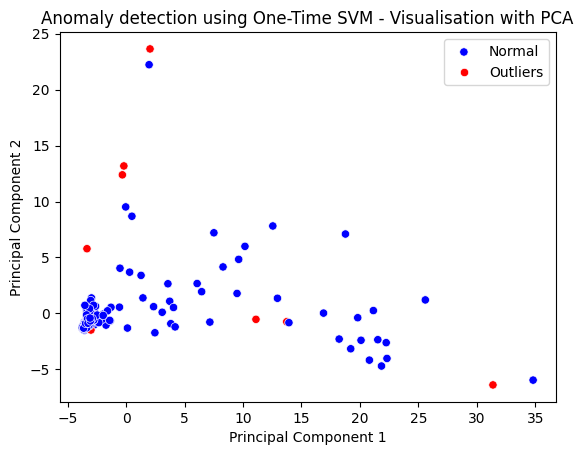

In [77]:
# Visualise the output in 2D after performing PCA with outliers in different colours
sns.scatterplot(x=gbd_pca[:, 0], y=gbd_pca[:, 1], hue=gbd_scaled['anomaly'], palette={1: "blue", -1: "red"})
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Anomaly detection using One-Time SVM - Visualisation with PCA')
plt.legend(labels=['Normal', 'Outliers'])

plt.show()

I would like to create a better visualisation.

In [78]:
# gbd_pca: result of PCA with 2 principal components
# gbd_scaled: scaled dataframe, index = country
# y_pred: One-Class SVM predictions (1 = normal, -1 = outlier)

pca_df = pd.DataFrame(
    gbd_pca,
    columns=["PC1", "PC2"],
    index=gbd_scaled.index
)

pca_df["country"] = pca_df.index
pca_df["anomaly"] = y_pred
pca_df["anomaly_label"] = pca_df["anomaly"].map({1: "Normal", -1: "Outlier"})
pca_df.head()

,PC1,PC2,country,anomaly,anomaly_label
location,,,,,
Afghanistan,-2.141018,-0.736427,Afghanistan,1,Normal
Albania,-3.570519,-1.252016,Albania,1,Normal
Algeria,-3.245081,-0.996062,Algeria,1,Normal
American Samoa,-3.176940,-0.869044,American Samoa,1,Normal
Andorra,-3.501304,-1.149486,Andorra,1,Normal


In [79]:
# Create plotly visualisation
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="anomaly_label",
    color_discrete_map={"Normal": "blue", "Outlier": "red"},
    hover_name="country",            # country shown when hovering
    hover_data={"PC1": True, "PC2": True, "anomaly_label": True},
    title="PCA of Cause-of-Death Profiles with SVM Anomalies"
)

fig.update_layout(
    width=900,
    height=600,
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    legend_title="Class"
)

fig.show()

I do not see Japan in the visualization.

In [80]:
pca_df.loc["Japan"]

,Japan
PC1,-3.68096
PC2,-1.304455
country,Japan
anomaly,-1
anomaly_label,Outlier


In [81]:
# Add Japan as a special big marker
japan_point = pca_df.loc[["Japan"]]
fig.add_scatter(
    x=japan_point["PC1"],
    y=japan_point["PC2"],
    mode="markers+text",
    text=["Japan"],
    textposition="top center",
    marker=dict(size=15, color="red", symbol="star"),
    name="Outlier",
    showlegend=True
)

fig.show()

In [82]:
# Build a tidy dataframe for mapping
map_df = pd.DataFrame({
    "country": gbd_scaled.index,
    "anomaly": y_pred
})

# Map numeric labels to readable categories
map_df["anomaly_label"] = map_df["anomaly"].map({1: "Normal", -1: "Outlier"})

In [126]:
# Map the anomalous countries in a world map
fig = px.choropleth(
    map_df,
    locations="country",
    locationmode="country names",
    color="anomaly_label",
    color_discrete_map={
        "Normal": "lightgrey",
        "Outlier": "red"
    },
    title="Anomalous Countries in Cause-of-Death Patterns (One-Class SVM)",
    hover_name="country",
    hover_data={"anomaly_label": True}
)

fig.update_layout(
    legend_title="Class",
    width=1000,
    height=500
)

fig.show()

A few countries do not show up on the map, so I will use their coordinates to indicate them on the map.

In [84]:
# Map small countries
small_countries = [
    "Monaco",
    "Mauritius",
    "Qatar",
    "Palestine",
    "Lesotho"
]

In [85]:
# Define coordinates
coords = {
    "Monaco": (43.7384, 7.4246),
    "Mauritius": (-20.3484, 57.5522),
    "Qatar": (25.3548, 51.1839),
    "Palestine": (31.9522, 35.2332),
    "Lesotho": (-29.61, 28.2336)
}

In [125]:
# Create the world map
fig = px.choropleth(
    map_df,
    locations="country",
    locationmode="country names",
    color="anomaly_label",
    color_discrete_map={
        "Normal": "lightgrey",
        "Outlier": "red"
    },
    title="Anomalous Countries in Cause-of-Death Patterns (One-Class SVM)"
)

# Filter to outlier + small countries
small_outliers = map_df[
    (map_df["anomaly_label"] == "Outlier") &
    (map_df["country"].isin(small_countries))
]

# Add star markers using coordinates
fig.add_scattergeo(
    lat=[coords[c][0] for c in small_outliers["country"]],
    lon=[coords[c][1] for c in small_outliers["country"]],
    text=small_outliers["country"],
    mode="markers",
    marker=dict(
        symbol="star",
        size=12,
        color="red",
        line=dict(width=1, color="black")
    ),
    name="Small outlier countries"
)

fig.update_layout(
    legend_title="Class",
    width=1000,
    height=500
)

fig.show()

Compared with the IQR method, which requires finding outliers in each feature individually, the One-Class SVM Model allows to determine outliers by looking at several features combined. Therefore, One-Class SVM is better at handling complex data in an efficient and user-friendly way. The next step is using Isolation Forest methodologies to detect anomalies. For this method, I will be using the unscaled dataset.

## Outlier detection using Isolation Forest


In [87]:
# View the dataframe
# gbd_scaled.head()

In [88]:
# remove anomaly column
gbd_scaled = gbd_scaled.drop('anomaly', axis=1)
# gbd_scaled.head()

The dataframe has the scaled values and the sixteen features, without the added anomaly columns.

In [89]:
# Define a function to run the Isolation Forest method for anomaly detection
def run_isolation_forest(gbd_scaled, n_estimators, contamination):
    # Fit Isolation Forest
    model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=42
    )
    model.fit(gbd_scaled)
    y_pred = model.predict(gbd_scaled)

    # Create results dataframe
    gbd_anomalies_IF = pd.DataFrame(index=gbd_scaled.index)
    gbd_anomalies_IF["outlier_IF"] = y_pred

    # Keep only outliers
    gbd_anomalies_IF = gbd_anomalies_IF[y_pred == -1]

    # Print results
    print(gbd_anomalies_IF.shape)

    print(
    "the percentage of outliers using Isolation Forest with contamination {} is: {}%"
    .format(contamination, len(gbd_anomalies_IF) / len(gbd_scaled) * 100)
    )

    return gbd_anomalies_IF

In [90]:
# Run the Isolation Forest function for anomaly detection
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 100, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eritrea,-1
Eswatini,-1
Guinea,-1


The percentage of outliers using the Isolation Forest method with contamination of 0.1 is 10.3%, which is quite high. I will try a lower proportion.

In [91]:
# change the number of estimators to 200 to see if the outlier change
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 200, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eswatini,-1
Guinea,-1
Japan,-1


South Africa has now replaced Ukraine. I will do it again with 300 n_estimators.

In [92]:
# change the number of estimators to 300
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 300, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eswatini,-1
Guinea,-1
Japan,-1


I will now increase to 500 or even 700 n_estimators if needed, until stability is reached.

In [93]:
# change the number of estimators to 500
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 500, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Afghanistan,-1
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eritrea,-1
Eswatini,-1


In [94]:
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 700, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Afghanistan,-1
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eritrea,-1
Eswatini,-1


Stabilisation is reached after 500 n_estimators. Let's see if 400 estimators has the same result.

In [95]:
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 400, 0.1)

gbd_anomalies_IF

(21, 1)
the percentage of outliers using Isolation Forest with contamination 0.1 is: 10.294117647058822%


,outlier_IF
location,
Benin,-1
Burundi,-1
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Equatorial Guinea,-1
Eswatini,-1
Guinea,-1
Japan,-1


With 400 n_estimators stability is not yet reached, but with 500 it is. Therefore, n_estimators needs to be set to 500. For this relatively small dataset, this is not computationally very intensive.

In [96]:
# Tune contamination for this model
for c in [0.03, 0.05, 0.07, 0.09]:

    model = IsolationForest(
        n_estimators=500,
        contamination=c,
        random_state=42
    )

    model.fit(gbd_scaled)
    y_pred = model.predict(gbd_scaled)

    n_outliers = (y_pred == -1).sum()

    print(
        "The percentage of outliers using Isolation Forest with contamination {} is: {:.2f}%"
        .format(c, n_outliers / len(gbd_scaled) * 100)
    )

The percentage of outliers using Isolation Forest with contamination 0.03 is: 3.43%
The percentage of outliers using Isolation Forest with contamination 0.05 is: 5.39%
The percentage of outliers using Isolation Forest with contamination 0.07 is: 7.35%
The percentage of outliers using Isolation Forest with contamination 0.09 is: 9.31%


As before, I would like the percentage of outliers for this dataset around 5% (between 3-7%). The best Isolation Forest model in this case has a contamination of 0.05 and n_estimators of 500.

In [97]:
# run the Isolation Forest function with 0.05 contamination and 500 n_estimators
gbd_anomalies_IF = run_isolation_forest(gbd_scaled, 500, 0.05)

gbd_anomalies_IF

(11, 1)
the percentage of outliers using Isolation Forest with contamination 0.05 is: 5.392156862745098%


,outlier_IF
location,
Central African Republic,-1
Chad,-1
Democratic Republic of the Congo,-1
Eswatini,-1
Lesotho,-1
Mali,-1
Monaco,-1
Niger,-1
Sierra Leone,-1


11 countries are now identified as outliers. As we can see, these are different countries than the ones identified using OneClass SVM.

Now I will use PCA to visualise the outliers from the Isolation Forest method, using the scaled dataset.

In [98]:
# Add Isolation Forest outlier column to the scaled dataset
gbd_scaled['outlier_IF'] = y_pred
# gbd_scaled.head()

In [99]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
gbd_pca = pca.fit_transform(gbd_scaled)

# view output
print('scaled data:', gbd_scaled.shape)
print('PCA data:', gbd_pca.shape)

scaled data: (204, 17)
PCA data: (204, 2)


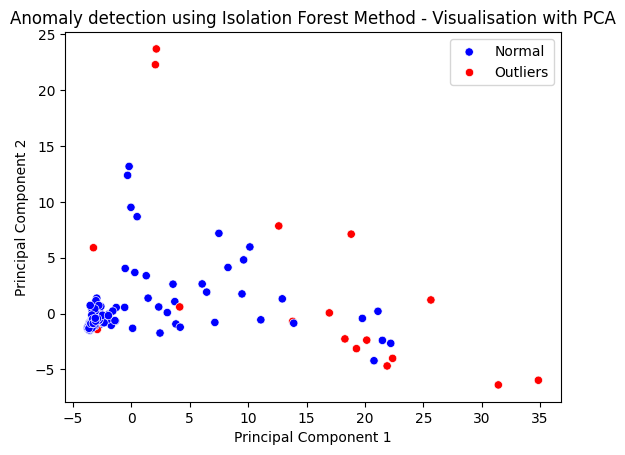

In [100]:
# Visualise the outliers of the Isolation Forest Method in 2D after performing PCA
sns.scatterplot(x=gbd_pca[:, 0], y=gbd_pca[:, 1], hue=gbd_scaled['outlier_IF'], palette=["red", "blue"])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Anomaly detection using Isolation Forest Method - Visualisation with PCA')
plt.legend(labels=['Normal', 'Outliers'])

plt.show()

Now, I will make the visualization using plotly. First, I will make a clean dataframe for the visualization.

In [101]:
# gbd_pca: result of PCA with 2 principal components
# gbd_scaled: scaled dataframe
# y_pred: One-Class SVM predictions from Isolation Forest (1 = normal, -1 = outlier)

pca_df = pd.DataFrame(
    gbd_pca,
    columns=["PC1", "PC2"],
    index=gbd_scaled.index
)

pca_df["country"] = pca_df.index
pca_df["anomaly"] = y_pred
pca_df["anomaly_label"] = pca_df["anomaly"].map({1: "Normal", -1: "Outlier"})
pca_df.head()

,PC1,PC2,country,anomaly,anomaly_label
location,,,,,
Afghanistan,-2.147562,-0.738117,Afghanistan,1,Normal
Albania,-3.575951,-1.252044,Albania,1,Normal
Algeria,-3.251122,-0.998338,Algeria,1,Normal
American Samoa,-3.182741,-0.870196,American Samoa,1,Normal
Andorra,-3.506747,-1.149592,Andorra,1,Normal


In [102]:
# Create plotly visualisation
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="anomaly_label",
    color_discrete_map={"Normal": "blue", "Outlier": "red"},
    hover_name="country",
    hover_data={"PC1": True, "PC2": True, "anomaly_label": True},
    title="PCA of Cause-of-Death Profiles with Isolation Forest Anomalies"
)

fig.update_layout(
    width=900,
    height=600,
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2",
    legend_title="Class"
)

fig.show()

All anomalous countries from the Isolation Forest model are shown on the plotly visualisation of Principal Components. Finally, I will create the world map for the Isolation Forest outlier results.

In [103]:
# Create a dataframe for the world map
map_df = pd.DataFrame({
    "country": gbd_scaled.index,
    "anomaly": y_pred
})

# Map numeric labels to readable categories
map_df["anomaly_label"] = map_df["anomaly"].map({1: "Normal", -1: "Outlier"})

In [ ]:
fig = px.choropleth(
    df_map,
    locations="location",
    locationmode="country names",
    color="outlier_flag",
    template="plotly_white"
)

fig.update_traces(
    marker_line_color="white",
    marker_line_width=0.8
)

In [124]:
# Map the anomalous countries in the world map
fig = px.choropleth(
    map_df,
    locations="country",
    locationmode="country names",
    color="anomaly_label",
    color_discrete_map={
        "Normal": "lightgrey",
        "Outlier": "red"
    },
    title="Anomalous Countries in Cause-of-Death Patterns (Isolation Forest)",
    hover_name="country",
    hover_data={"anomaly_label": True}
)

fig.update_layout(
    legend_title="Class",
    width=1000,
    height=500
)

fig.show()

Eswatini and Monaco are not shown on the map as they are very small countries. I will indicate them with a star. I will also add Lesotho: it is shown, but very small and will be overshadowed by the star indicating Eswatini.

In [105]:
# Map small countries
small_countries = [
    "Monaco",
    "Eswatini",
    "Lesotho"
]

# Define coordinates
coords = {
    "Monaco": (43.7384, 7.4246),
    "Eswatini": (-26.3158, 31.1391),
    "Lesotho": (-29.61, 28.2336)
}

In [106]:
# Create the world map
fig = px.choropleth(
    map_df,
    locations="country",
    locationmode="country names",
    color="anomaly_label",
    color_discrete_map={
        "Normal": "lightgrey",
        "Outlier": "red"
    },
    title="Anomalous Countries in Cause-of-Death Patterns (Isolation Forest)"
)

# Filter to outlier and small countries
small_outliers = map_df[
    (map_df["anomaly_label"] == "Outlier") &
    (map_df["country"].isin(small_countries))
]

# Add star using coordinates
fig.add_scattergeo(
    lat=[coords[c][0] for c in small_outliers["country"]],
    lon=[coords[c][1] for c in small_outliers["country"]],
    text=small_outliers["country"],
    mode="markers",
    marker=dict(
        symbol="star",
        size=12,
        color="red",
        line=dict(width=1, color="black")
    ),
    name="Small outlier countries"
)

fig.update_layout(
    legend_title="Class",
    width=1000,
    height=500
)

fig.show()

# Reflect

Both One-Class SVM and Isolation Forest methods are very effective in finding anomalies in large datasets.  Because Isolation Forest methods focus on finding the outliers first, while One-Class SVM focuses on finding normal data point first, the Isolation Forest methods are more efficient for very large datasets. Because both are unsupervised machine learning models, and the y is unknown, it is unknown which model predicts the anomalies more accurately.

However, in this case, using the more classical IQR method for anomaly detection has an important advantage due to interpretability of the results. It allows to look at the number of features in which outliers are found and it allows to look at a specific country to show which specific disease categories have outliers.

## Reference:


Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2023 (GBD 2023) Cause-Specific Mortality 1990-2023. Seattle, United States of America: Institute for Health Metrics and Evaluation (IHME), 2025.


University of Cambridge, Institute of Continuing Education, 2025. CAM_DS_101 Applying statistics and core data science techniques in business: 5.2.4 Applying isolation forest methodologies. Available at: https://fourthrev.instructure.com/courses/840/modules [Accessed: 31 March 2025]. Password protected.